Top Recommendations for User 10:

                               title     score
78              Fugitive, The (1993)  2.613021
171  Empire Strikes Back, The (1980)  2.371805
180        Return of the Jedi (1983)  2.126573
203        Back to the Future (1985)  2.122281
317          Schindler's List (1993)  2.094769

Precision@5 for User 10: 0.0

Item-Based CF Recommendations for User 10:

                                 title       score
78                Fugitive, The (1993)  327.715430
88                 Blade Runner (1982)  318.155628
171    Empire Strikes Back, The (1980)  317.498715
203          Back to the Future (1985)  312.632345
422  E.T. the Extra-Terrestrial (1982)  311.699217

SVD Recommendations for User 10:

                              title     score
7                       Babe (1995)  4.119473
186  Godfather: Part II, The (1974)  4.079950
317         Schindler's List (1993)  3.909706
426    To Kill a Mockingbird (1962)  3.850498
513               Annie Hall (1977)  3

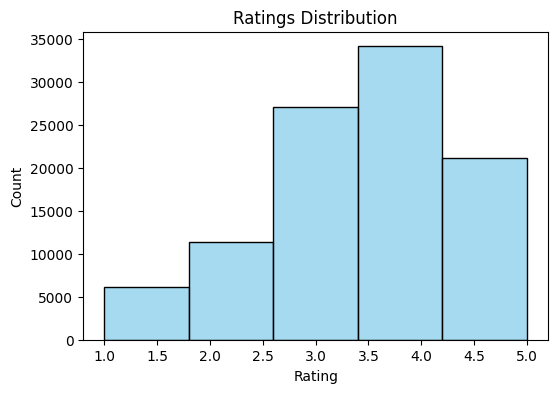

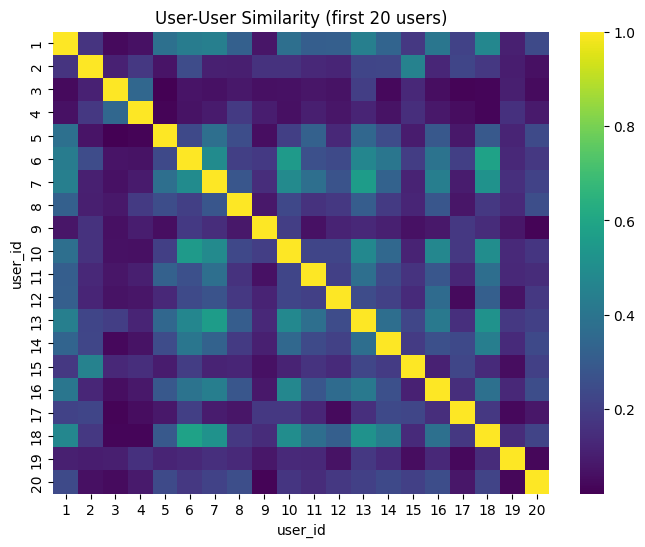

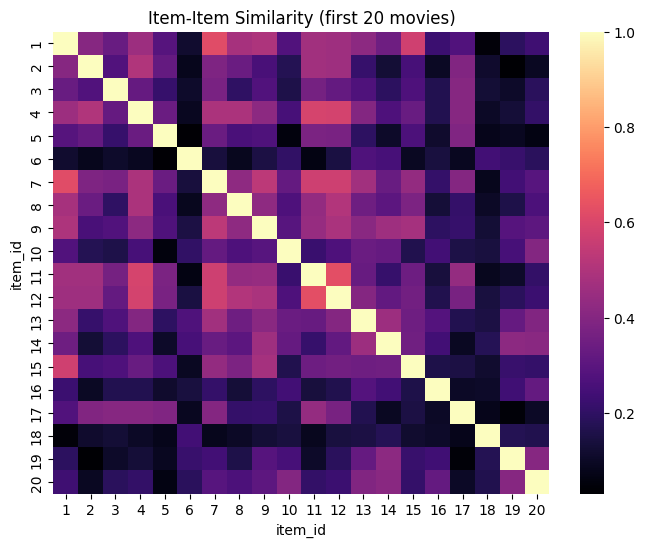

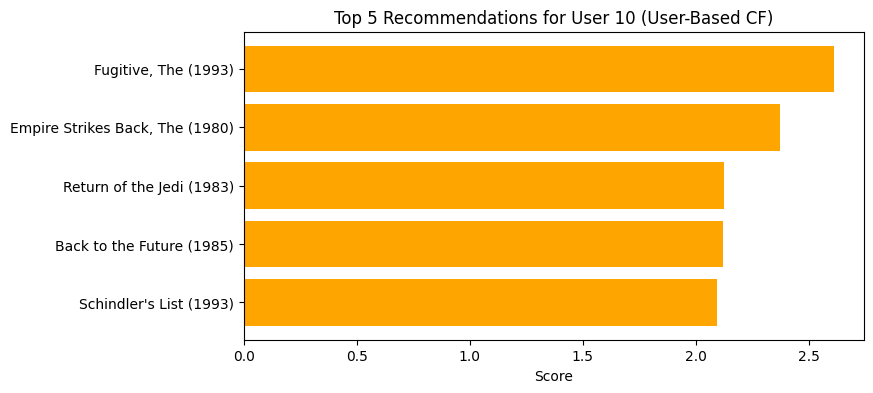

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD

# =============================
# Load Dataset
# =============================
ratings_path = r"F:\elevvo\ml-100k\u.data"
movies_path = r"F:\elevvo\ml-100k\u.item"

ratings = pd.read_csv(ratings_path, sep="\t", names=["user_id", "item_id", "rating", "timestamp"])
movies = pd.read_csv(movies_path, sep="|", encoding="latin-1", header=None, usecols=[0, 1], names=["item_id", "title"])
data = pd.merge(ratings, movies, on="item_id")

# =============================
# Build User-Item Matrix
# =============================
user_item_matrix = data.pivot_table(index="user_id", columns="item_id", values="rating")
user_item_matrix_filled = user_item_matrix.fillna(0)

# =============================
# Compute User-User Similarity
# =============================
user_similarity = cosine_similarity(user_item_matrix_filled)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

# =============================
# Recommendation Function (User-Based)
# =============================
def recommend_movies(user_id, top_n=5):
    sim_scores = user_similarity_df[user_id]
    weighted_ratings = user_item_matrix_filled.T.dot(sim_scores)
    norm_factors = sim_scores.sum()
    recommendations = weighted_ratings / norm_factors
    seen_movies = user_item_matrix.loc[user_id].dropna().index
    recommendations = recommendations.drop(seen_movies, errors="ignore")
    top_recs = recommendations.sort_values(ascending=False).head(top_n)
    return movies[movies["item_id"].isin(top_recs.index)][["title"]].assign(score=top_recs.values)

# =============================
# Evaluation: Precision@K (Fixed)
# =============================
def precision_at_k(user_id, k=5, threshold=3):

    recommended = recommend_movies(user_id, top_n=k)

    if recommended.empty:
        return 0.0  # no recommendations

    rec_ids = movies[movies["title"].isin(recommended["title"])]["item_id"].values
    true_ratings = user_item_matrix.loc[user_id].dropna()

    rec_ids = [i for i in rec_ids if i in true_ratings.index]
    if len(rec_ids) == 0:
        return 0.0  # no overlap with rated items

    relevant = (true_ratings[rec_ids] >= threshold).sum()
    return relevant / k

# =============================
# Precision@K for multiple users
# =============================
precisions = {}
for u in range(1, 21):   # users 1–20
    try:
        precisions[u] = precision_at_k(u, k=5)
    except Exception as e:
        precisions[u] = 0.0



# =============================
# Example Run (User-Based CF)
# =============================
user_id = 10
print(f"Top Recommendations for User {user_id}:\n")
print(recommend_movies(user_id, top_n=5))
print("\nPrecision@5 for User 10:", precision_at_k(user_id, k=5))

# =============================
# BONUS PART 1: Item-Based CF
# =============================
item_similarity = cosine_similarity(user_item_matrix_filled.T)
item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

def recommend_movies_item_based(user_id, top_n=5):
    user_ratings = user_item_matrix.loc[user_id].dropna()
    scores = pd.Series(dtype=float)
    for item, rating in user_ratings.items():
        sims = item_similarity_df[item] * rating
        scores = scores.add(sims, fill_value=0)
    scores = scores.drop(user_ratings.index, errors="ignore")
    top_recs = scores.sort_values(ascending=False).head(top_n)
    return movies[movies["item_id"].isin(top_recs.index)][["title"]].assign(score=top_recs.values)

print("\nItem-Based CF Recommendations for User 10:\n")
print(recommend_movies_item_based(user_id, top_n=5))

# =============================
# BONUS PART 2: Matrix Factorization (SVD)
# =============================
svd = TruncatedSVD(n_components=20, random_state=42)
latent_matrix = svd.fit_transform(user_item_matrix_filled)
latent_features = svd.components_

def recommend_movies_svd(user_id, top_n=5):
    user_vector = latent_matrix[user_id - 1]  # adjust index
    scores = np.dot(user_vector, latent_features)
    seen_movies = user_item_matrix.loc[user_id].dropna().index
    recs = pd.Series(scores, index=user_item_matrix.columns)
    recs = recs.drop(seen_movies, errors="ignore")
    top_recs = recs.sort_values(ascending=False).head(top_n)
    return movies[movies["item_id"].isin(top_recs.index)][["title"]].assign(score=top_recs.values)

print("\nSVD Recommendations for User 10:\n")
print(recommend_movies_svd(user_id, top_n=5))

# =============================
# VISUALIZATIONS
# =============================

# Ratings distribution
plt.figure(figsize=(6,4))
sns.histplot(ratings["rating"], bins=5, kde=False, color="skyblue")
plt.title("Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# User similarity heatmap
plt.figure(figsize=(8,6))
sns.heatmap(user_similarity_df.iloc[:20, :20], cmap="viridis")
plt.title("User-User Similarity (first 20 users)")
plt.show()

# Item similarity heatmap
plt.figure(figsize=(8,6))
sns.heatmap(item_similarity_df.iloc[:20, :20], cmap="magma")
plt.title("Item-Item Similarity (first 20 movies)")
plt.show()



# Example recommendation scores bar chart
top_recs = recommend_movies(user_id, top_n=5)
plt.figure(figsize=(8,4))
plt.barh(top_recs["title"], top_recs["score"], color="orange")
plt.xlabel("Score")
plt.title(f"Top 5 Recommendations for User {user_id} (User-Based CF)")
plt.gca().invert_yaxis()
plt.show()
